In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

from survivors.ensemble import BootstrapCRAID
import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


### Metrics

In [2]:
def loglikelihood(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf = np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    sf_by_times = np.take_along_axis(sf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10
    hf_by_times = (np.take_along_axis(hf, index_times[:, np.newaxis], axis=1)[:, 0] + 1e-10)**cens
    likelihood = np.sum(np.log(sf_by_times) + np.log(hf_by_times))
    return likelihood

def kl(time, cens, sf, cumhf, bins):
    eq_sf = np.array([np.where(time > t, 1, 0)
                      for i, t in enumerate(bins)]).T
    
    kl_v = np.sum(sf * np.log((sf + 1e-10)/(eq_sf + 1e-10)) + np.abs(sf - eq_sf), axis=0)
    return np.trapz(kl_v, bins, axis=0) / (bins[-1] - bins[0])

In [18]:
def ibs(*args, **kwargs):
    return metr.ibs(*args, **kwargs)

def bal_ibs(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return (ibs_event + ibs_cens)/2

def ibs_WW(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    
    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time <= t, 
                                      estim_before[:, i], 
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    if axis == -1:  # mean ibs for each time and observation
        brier_scores = np.mean(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / (times[-1] - times[0])
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / (times[-1] - times[0])
    elif axis == 1:  # bs in time (for graphics)
        return np.mean(brier_scores, axis=1)
    return None

def bal_ibs_WW(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs_WW(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs_WW(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return (ibs_event + ibs_cens)/2


def ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test, allow_all_censored=True)
    estimate = np.array(estimate)
    if estimate.ndim == 1 and times.shape[0] == 1:
        estimate = estimate.reshape(-1, 1)
    estimate[estimate == -np.inf] = 0
    estimate[estimate == np.inf] = 0
    
    estim_before = np.square(estimate) * test_event[np.newaxis, :].T
    estim_after = np.square(1 - estimate)
    brier_scores = np.array([np.where(test_time < t, 
                                      estim_before[:, i], 
                                      estim_after[:, i])
                             for i, t in enumerate(times)])
    
    ind = np.digitize(test_time, times) - 1
    n_cens = np.bincount(ind[~test_event], minlength=times.shape[0])
    
    N = np.ones(times.shape)*np.sum(test_event)
    if n_cens.shape[0] > 0:
        N += np.cumsum(n_cens[::-1])[::-1]

    if axis == -1:  # mean ibs for each time and observation
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1/N, 0) * np.sum(brier_scores, axis=1)
        return np.trapz(brier_scores, times) / (times[-1] - times[0])
    elif axis == 0:  # ibs for each observation
        return np.trapz(brier_scores, times, axis=0) / (times[-1] - times[0])
    elif axis == 1:  # bs in time (for graphics)
        # brier_scores = np.mean(brier_scores, axis=1)
        brier_scores = np.where(N > 0, 1/N, 0) * np.sum(brier_scores, axis=1)        
        return brier_scores
    return None

def bal_ibs_remain(survival_train, survival_test, estimate, times, axis=-1):
    ibs_event = ibs_remain(survival_train, survival_test[survival_test["cens"]],
                    estimate[survival_test["cens"]], times, axis=axis)
    ibs_cens = ibs_remain(survival_train, survival_test[~survival_test["cens"]],
                   estimate[~survival_test["cens"]], times, axis=axis)
    return (ibs_event + ibs_cens)/2

ibs_list = [ibs, bal_ibs, 
            ibs_WW, bal_ibs_WW,
            ibs_remain, bal_ibs_remain]

In [4]:
import sksurv.metrics
import numpy as np
from numba import njit, jit
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.utils import concordance_index

def iauc(survival_train, survival_test, estimate, times, tied_tol=1e-8, axis=-1):
    if survival_train["cens"].sum() == 0:
        survival_train["cens"] = 1
        survival_test["cens"] = 1 - survival_test["cens"]
    if survival_test["cens"].sum() == 0:
        survival_test["cens"] = 1
    test_event, test_time = sksurv.metrics.check_y_survival(survival_test)
    # estimate, times = _check_estimate_2d(estimate, test_time, times)
    estimate = np.array(estimate)
    n_samples = estimate.shape[0]
    n_times = times.shape[0]
    if estimate.ndim == 1:
        estimate = np.broadcast_to(estimate[:, np.newaxis], (n_samples, n_times))

    # fit and transform IPCW
    cens = sksurv.metrics.CensoringDistributionEstimator()
    cens.fit(survival_train)
    Ghat = cens.predict_proba(test_time[test_event])
    ipcw = np.zeros(test_time.shape[0])
    Ghat[Ghat == 0] = np.inf
    if not((Ghat == 0.0).any()):
        ipcw[test_event] = 1.0 / Ghat
    else:
        ipcw = np.ones(test_time.shape[0])

    # expand arrays to (n_samples, n_times) shape
    test_time = np.broadcast_to(test_time[:, np.newaxis], (n_samples, n_times))
    test_event = np.broadcast_to(test_event[:, np.newaxis], (n_samples, n_times))
    times_2d = np.broadcast_to(times, (n_samples, n_times))
    ipcw = np.broadcast_to(ipcw[:, np.newaxis], (n_samples, n_times))

    # sort each time point (columns) by risk score (descending)
    o = np.argsort(-estimate, axis=0)
    test_time = np.take_along_axis(test_time, o, axis=0)
    test_event = np.take_along_axis(test_event, o, axis=0)
    estimate = np.take_along_axis(estimate, o, axis=0)
    ipcw = np.take_along_axis(ipcw, o, axis=0)

    is_case = (test_time <= times_2d) & test_event
    is_control = test_time > times_2d
    n_controls = is_control.sum(axis=0)

    # prepend row of infinity values
    estimate_diff = np.concatenate((np.broadcast_to(np.infty, (1, n_times)), estimate))
    is_tied = np.absolute(np.diff(estimate_diff, axis=0)) <= tied_tol

    cumsum_tp = np.cumsum(is_case * ipcw, axis=0)
    cumsum_fp = np.cumsum(is_control, axis=0)
    true_pos = cumsum_tp / cumsum_tp[-1]
    false_pos = cumsum_fp / n_controls

    scores = np.empty(n_times, dtype=float)
    it = np.nditer((true_pos, false_pos, is_tied), order="F", flags=["external_loop"])
    with it:
        for i, (tp, fp, mask) in enumerate(it):
            idx = np.flatnonzero(mask) - 1
            # only keep the last estimate for tied risk scores
            tp_no_ties = np.delete(tp, idx)
            fp_no_ties = np.delete(fp, idx)
            # Add an extra threshold position
            # to make sure that the curve starts at (0, 0)
            tp_no_ties = np.r_[0, tp_no_ties]
            fp_no_ties = np.r_[0, fp_no_ties]
            scores[i] = np.trapz(tp_no_ties, fp_no_ties)

    scores[np.isnan(scores)] = 0
    if n_times == 1:
        return scores[0]
    
    if axis == -1:  # mean iauc for each time and observation
        surv = KaplanMeierFitter()
        surv.fit(survival_test["time"], survival_test["cens"]) 
        s_times = surv.survival_function_at_times(times).to_numpy()
        
        # compute integral of AUC over survival function
        d = -np.diff(np.r_[1.0, s_times])
        integral = (scores * d).sum()
        return integral / (1.0 - s_times[-1])
    elif axis == -2:
        surv = KaplanMeierFitter()
        surv.fit(survival_test["time"], survival_test["cens"]) 
        s_times = surv.survival_function_at_times(times).to_numpy()
        
        return np.trapz(scores, -s_times) / (s_times[0] - s_times[-1])
    elif axis == 0:  # ibs for each observation
        return None
    elif axis == 1:  # bs in time (for graphics)
        return scores
    return mean_auc

### Datasets loading

In [134]:
import survivors.datasets as ds
# X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X, y, features, categ, sch_nan = ds.load_smarto_dataset()

### Bins schemes

In [135]:
def bins_scheme(val, scheme=""):
    if scheme == "rank":
        u = np.unique(val)
        ind = np.digitize(val, u)
        return (ind * val.max() / ind.max()).astype("int")
    if scheme == "quantile":
        u = np.unique(np.quantile(val, np.linspace(0, 1, 100)))
        # u = np.hstack([0.0, np.quantile(val, np.linspace(0, 1, 100)), val.max()])
        ind = np.digitize(val, u)
        return (ind * val.max() / ind.max()).astype("int")  # u[ind].astype("int")
    if scheme == "log+scale":
        a = np.log(val+1)
        v = (val.max() - val.min())*(a - a.min())/(a.max() - a.min()) + val.min()
        return v.astype("int")
    return val

(-173.3, 3639.3)

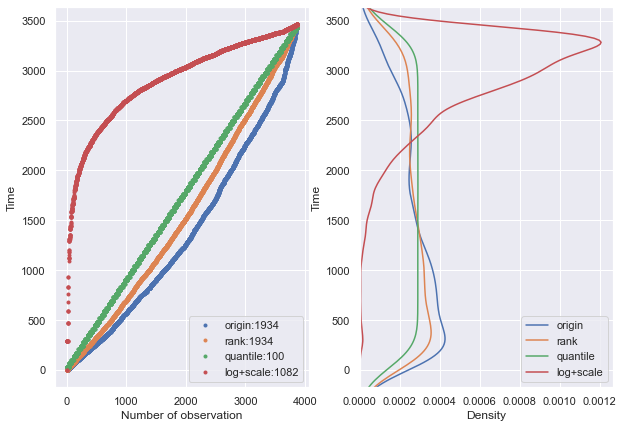

In [136]:
fig, axes = plt.subplots(figsize=(10, 7), ncols=2)
for scheme in ["origin", "rank", "quantile", "log+scale"]:
    y_new = y.copy()
    #y_new[np.argmax(y_new["time"] * y_new["cens"])]["time"] = 1000
    y_ = np.sort(bins_scheme(y_new["time"], scheme=scheme))
    axes[0].plot(y_, label=f"{scheme}:{np.unique(y_).shape[0]}", marker='o', markersize=3, linestyle="")
    
    sns.kdeplot(y=bins_scheme(y_new["time"], scheme=scheme), label=f"{scheme}", ax=axes[1])
axes[0].legend()
axes[0].set_xlabel("Number of observation")
axes[0].set_ylabel("Time")

axes[1].legend()
axes[1].set_ylabel("Time")


ymin, ymax = axes[0].get_ylim()
axes[1].set_ylim(ymin, ymax)

### Dependence IBS on true event time

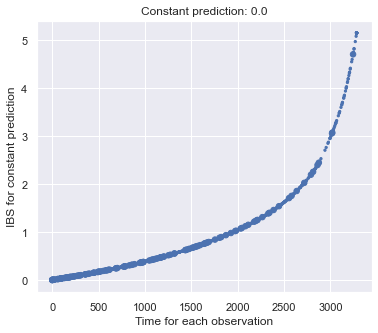

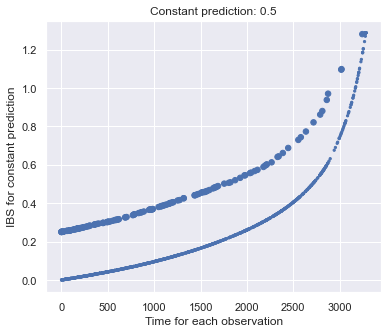

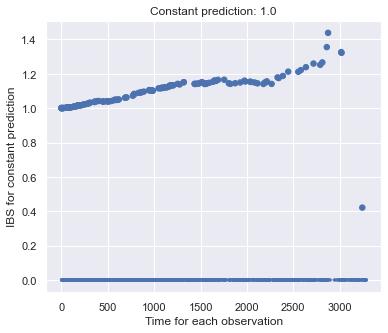

In [137]:
from survivors.experiments.grid import generate_sample
for cnt_p in [0.0, 0.5, 1.0]:
    plt.figure(figsize=(6, 5))
    for scheme in ["origin"]:
        y_new = y.copy()
        y_new["time"] = bins_scheme(y_new["time"], scheme=scheme)
        for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y_new, 5, "CV+HOLD-OUT"):
            pass
        ibs_all = ibs(y_tr, y_HO, np.ones((y_HO.shape[0], bins.shape[0]))*cnt_p, bins, axis=-1)
        ibs_cnt_p = ibs(y_tr, y_HO, np.ones((y_HO.shape[0], bins.shape[0]))*cnt_p, bins, axis=0)
        plt.scatter(y_HO["time"], ibs_cnt_p, label=f"{scheme}:{ibs_all:.5f}", s=np.where(y_HO["cens"], 30, 5))
    plt.title(f"Constant prediction: {cnt_p}")
    plt.xlabel("Time for each observation")
    plt.ylabel("IBS for constant prediction")
    plt.show()

### Dependence IBS and IAUC on bins

Text(0, 0.5, 'BS(Time)')

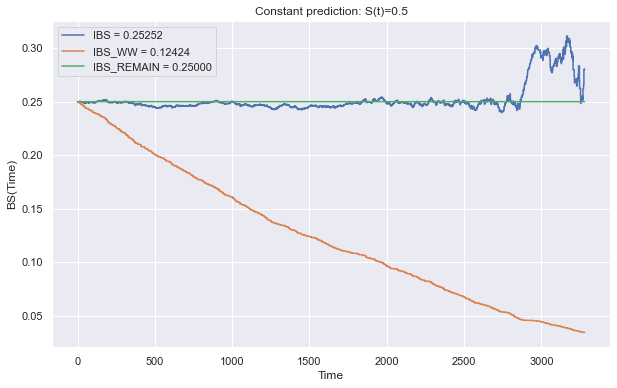

In [138]:
from survivors.experiments.grid import generate_sample
for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
    pass

plt.figure(figsize=(10, 6))
for m in [ibs, ibs_WW, ibs_remain]:
    for i in [0]:
        bins = bins[:-1]
        base_sf = np.ones((y_HO.shape[0], bins.shape[0]))*0.5
        
        ibs_all = m(y_tr, y_HO, base_sf, bins, axis=1)
        ibs_mean = m(y_tr, y_HO, base_sf, bins, axis=-1)
        plt.step(bins, ibs_all,  label=f"{m.__name__.upper()} = {ibs_mean:.5f}")
        
plt.legend()
plt.title(f"Constant prediction: S(t)=0.5")
plt.xlabel("Time")
plt.ylabel("BS(Time)")

Text(0, 0.5, 'AUC(Time)')

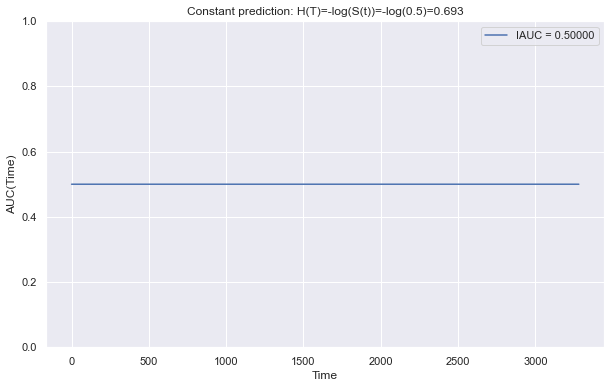

In [141]:
from survivors.experiments.grid import generate_sample
for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
    pass

plt.figure(figsize=(10, 6))
for m in [iauc]:
    bins = bins[:-1]
    base_sf = np.ones((y_HO.shape[0], bins.shape[0]))*0.5
    base_hf = -np.log(base_sf)
    kmf = KaplanMeierFitter()

    kmf.fit(y_HO["time"], y_HO["cens"])
    one_km_sf = kmf.survival_function_at_times(bins).to_numpy()
    km_sf = np.repeat(kmf.survival_function_at_times(bins).to_numpy()[np.newaxis, :], y_HO.shape[0], axis=0)
    base_hf = -np.log(km_sf)

    ibs_all = m(y_tr, y_HO, base_hf, bins, axis=1)
    ibs_mean = m(y_tr, y_HO, base_hf, bins, axis=-1)
    plt.step(bins, ibs_all,  label=f"{m.__name__.upper()} = {ibs_mean:.5f}") #label=f"max bins:{max_time}, ibs={ibs_mean:.5f}")

# plt.step(bins, km_sf[0])
plt.legend()
plt.ylim((0.0, 1.0))
plt.title(f"Constant prediction: H(T)=-log(S(t))=-log(0.5)=0.693")
plt.xlabel("Time")
plt.ylabel("AUC(Time)")

Text(0, 0.5, 'Impact')

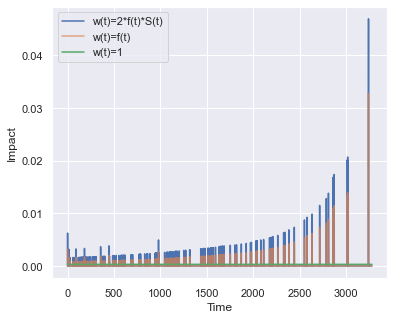

In [140]:
f_est = np.hstack([0.0, -np.diff(np.log(one_km_sf))])
plt.figure(figsize=(6, 5))
plt.step(bins, 2*one_km_sf*f_est,  label=f"w(t)=2*f(t)*S(t)", alpha=1)
plt.step(bins, f_est,  label=f"w(t)=f(t)", alpha=0.7)
plt.step(bins, np.ones_like(bins)/(bins[-1] - bins[0]), label=f"w(t)=1")
# plt.step(bins, km_sf[0])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Impact")

Text(0, 0.5, 'Impact')

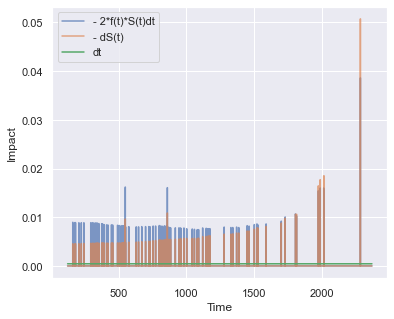

In [109]:
plt.figure(figsize=(6, 5))
plt.step(bins[1:], -1*np.diff(km_sf**2)[0],  label=f"- 2*f(t)*S(t)dt", alpha=0.7)
plt.step(bins[1:], -1*np.diff(km_sf)[0],  label=f"- dS(t)", alpha=0.7)
# plt.step(bins, km_sf[0])
plt.step(bins[1:], np.diff(bins)/(bins[-1] - bins[0]), label=f"dt")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Impact")

### Disbalance analysis

Text(0, 0.5, 'BS_BAL(Time)')

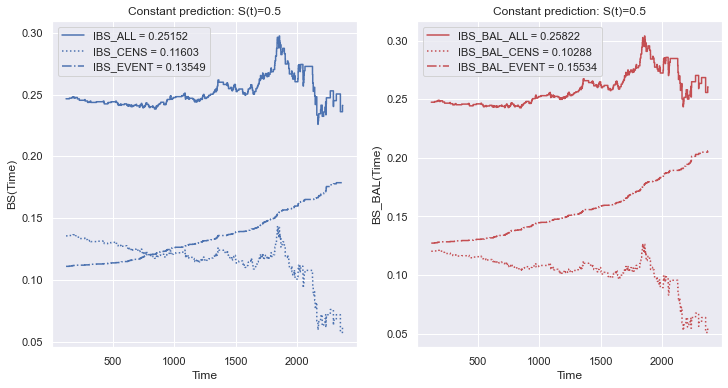

In [9]:
from survivors.experiments.grid import generate_sample
for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
    pass

fig, axes = plt.subplots(figsize=(12, 6), ncols=2)
bins = bins[:-1]
best_sf = np.ones((y_HO.shape[0], bins.shape[0]))*0.5
best_hf = -np.log(best_sf)

N_event = np.sum(y_HO["cens"])
N_cens = y_HO.shape[0] - N_event
N = y_HO.shape[0]

ibs_event = ibs(y_tr, y_HO[y_HO["cens"]], best_sf[y_HO["cens"]], bins, axis=1)
ibs_event_val = ibs(y_tr, y_HO[y_HO["cens"]], best_sf[y_HO["cens"]], bins, axis=-1)

ibs_cens = ibs(y_tr, y_HO[~y_HO["cens"]], best_sf[~y_HO["cens"]], bins, axis=1)
ibs_cens_val = ibs(y_tr, y_HO[~y_HO["cens"]], best_sf[~y_HO["cens"]], bins, axis=-1)

ibs_all = ibs(y_tr, y_HO, best_sf, bins, axis=1)
ibs_all_val = ibs(y_tr, y_HO, best_sf, bins, axis=-1)

ibs_bal = bal_ibs(y_tr, y_HO, best_sf, bins, axis=1)
ibs_bal_mean = bal_ibs(y_tr, y_HO, best_sf, bins, axis=-1)

#plt.fill_between(bins_, ibs_all, step="pre", alpha=0.3)
axes[0].step(bins, ibs_all,  label=f"IBS_ALL = {ibs_all_val:.5f}", color="b")
axes[0].step(bins, N_cens/N*ibs_cens,  label=f"IBS_CENS = {N_cens/N*ibs_cens_val:.5f}", ls=':', color="b")
axes[0].step(bins, N_event/N*ibs_event,  label=f"IBS_EVENT = {N_event/N*ibs_event_val:.5f}", ls='-.', color="b")

axes[1].step(bins, ibs_bal,  label=f"IBS_BAL_ALL = {ibs_bal_mean:.5f}", color="r")
axes[1].step(bins, ibs_cens/2,  label=f"IBS_BAL_CENS = {ibs_cens_val/2:.5f}", ls=':', color="r")
axes[1].step(bins, ibs_event/2,  label=f"IBS_BAL_EVENT = {ibs_event_val/2:.5f}", ls='-.', color="r")
#     plt.step(bins, ibs_bal,  label=f"IBS_BAL = {ibs_bal_mean:.5f}", color="r")
        
axes[0].legend()
axes[1].legend()
axes[0].set_title(f"Constant prediction: S(t)=0.5")
axes[1].set_title(f"Constant prediction: S(t)=0.5")
axes[0].set_xlabel("Time")
axes[1].set_xlabel("Time")
axes[0].set_ylabel("BS(Time)")
axes[1].set_ylabel("BS_BAL(Time)")